In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import fits

Text(0, 0.5, 'y (pixels)')

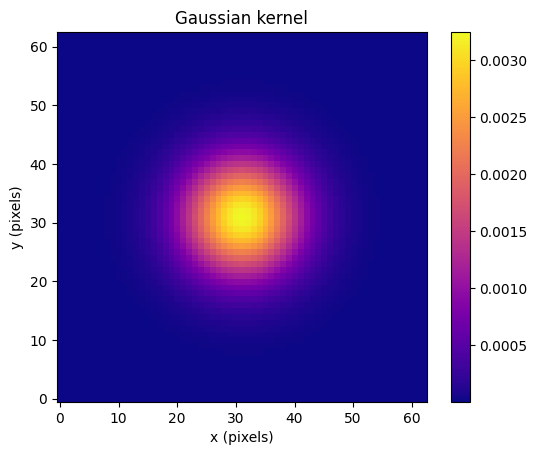

In [2]:
size = 7
gaussian_kernel = Gaussian2DKernel(size, size, x_size=9*size)
plt.imshow(gaussian_kernel, origin = 'lower', cmap='plasma')
plt.colorbar()
plt.title("Gaussian kernel")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

256


Text(0, 0.5, 'y (pixels)')

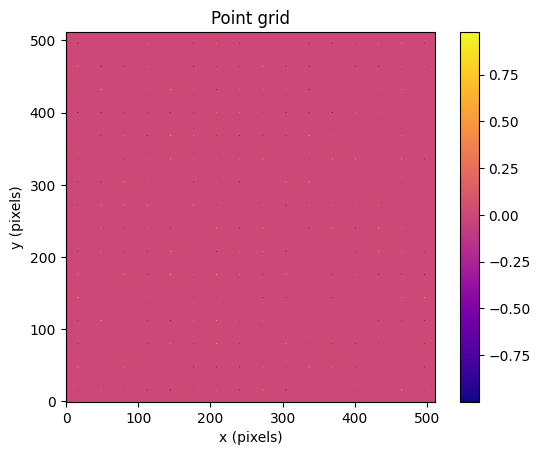

In [3]:
n = 512
dist = 32
mid = 16
#start = n/2 - n/(spacing*2)

Z = np.zeros((n, n))
actuator_number = 0

for i in range(mid, n, dist):
    for j in range(mid, n, dist):
        Z[i, j] = 2 * np.random.rand() - 1
        actuator_number = actuator_number + 1

plt.imshow(Z, origin='lower', cmap='plasma')
plt.colorbar()
print(actuator_number)
plt.title("Point grid")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

[[-7.04427750e-06 -9.66529965e-06 -1.29936462e-05 ... -1.57392757e-05
  -1.19490171e-05 -8.88825421e-06]
 [-9.66529965e-06 -1.32615470e-05 -1.78282988e-05 ... -2.15955172e-05
  -1.63949859e-05 -1.21953799e-05]
 [-1.29936462e-05 -1.78282988e-05 -2.39676590e-05 ... -2.90321583e-05
  -2.20407700e-05 -1.63949859e-05]
 ...
 [-4.01021862e-05 -5.50233358e-05 -7.39711942e-05 ... -7.64251003e-05
  -5.80207657e-05 -4.31586391e-05]
 [-3.04449656e-05 -4.17728739e-05 -5.61577978e-05 ... -5.80207657e-05
  -4.40484767e-05 -3.27653778e-05]
 [-2.26464313e-05 -3.10726749e-05 -4.17728739e-05 ... -4.31586391e-05
  -3.27653778e-05 -2.43724656e-05]]


Text(0.5, 1.0, 'Gaussian grid')

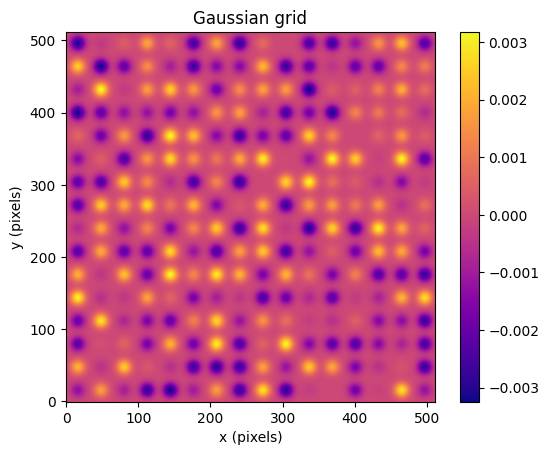

In [4]:
grid_convolved = convolve(Z, gaussian_kernel)
plt.imshow(grid_convolved, origin='lower', cmap='plasma')
plt.colorbar()
print(grid_convolved)
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.title("Gaussian grid")

True
amplitudes shape: (512,)
grid_convolved shape: (512, 512)


Text(0, 0.5, 'y (pixels)')

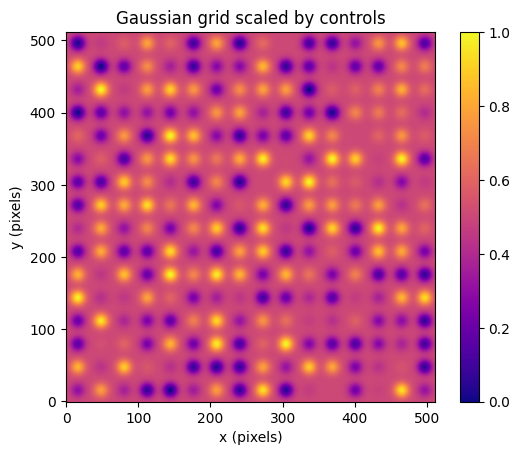

In [6]:
#scale_factor = 100
#scaled_dm = scale_factor * grid_convolved

amplitudes = np.linspace(-1, 1, n)
print(amplitudes.shape[0] == grid_convolved.shape[0])
print("amplitudes shape:", amplitudes.shape)
print("grid_convolved shape:", grid_convolved.shape)

min_val = 0
max_val = 1

grid_convolved_min = grid_convolved.min()
grid_convolved_max = grid_convolved.max()

scaled_dm = (grid_convolved - grid_convolved_min) * (max_val - min_val)/(grid_convolved_max - grid_convolved_min) + min_val
plt.imshow(scaled_dm, origin='lower', cmap="plasma")
plt.colorbar()
plt.title("Gaussian grid scaled by controls")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

Text(0, 0.5, 'y (pixels)')

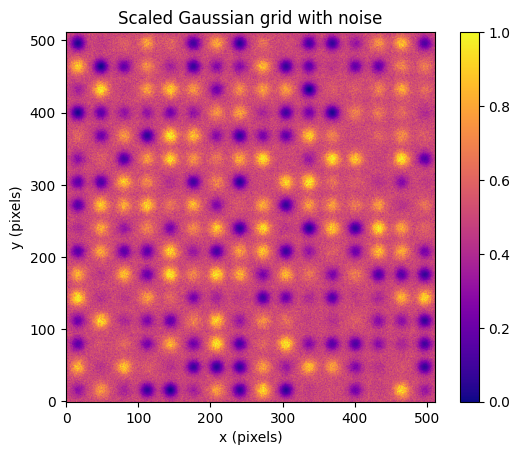

In [7]:
mean = 0
std_dev = 0.1
noise = np.random.normal(loc = mean, scale = std_dev*scaled_dm, size = scaled_dm.shape)
scaled_dm = scaled_dm + noise
scaled_dm = np.clip(scaled_dm, min_val, max_val)
plt.imshow(scaled_dm, origin = 'lower', cmap = "plasma")
plt.colorbar()
plt.title("Scaled Gaussian grid with noise")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")

20.480000000000018
245.76
266.24
Done
[[ 3.37093336e-04+1.23289400e-04j  3.28883957e-04+1.39093189e-04j
   3.19582010e-04+1.54182403e-04j ...  3.54606405e-04+7.25348820e-05j
   3.50001915e-04+8.99108004e-05j  3.44149924e-04+1.06862877e-04j]
 [-8.00645850e-04+9.30411422e-05j -8.01341132e-04+5.56061214e-05j
  -7.99414115e-04+1.83445112e-05j ... -7.82791788e-04+2.04255897e-04j
  -7.91355829e-04+1.67579190e-04j -7.97315433e-04+1.30436713e-04j]
 [ 1.24884480e-03-3.10419585e-04j  1.25855958e-03-2.51990635e-04j
   1.26416342e-03-1.93182460e-04j ...  1.19553345e-03-4.80145790e-04j
   1.21725318e-03-4.24820776e-04j  1.23505455e-03-3.68138589e-04j]
 ...
 [ 1.06368093e-03-7.27645964e-04j  1.09650547e-03-6.78125170e-04j
   1.12580837e-03-6.26414977e-04j ...  9.46095017e-04-8.60425955e-04j
   9.88251702e-04-8.19042162e-04j  1.02752520e-03-7.74703565e-04j]
 [-6.03385138e-04+5.37263447e-04j -6.28486737e-04+5.09245770e-04j
  -6.51586535e-04+4.79498116e-04j ... -5.17627451e-04+6.09476225e-04j
  -5.4778

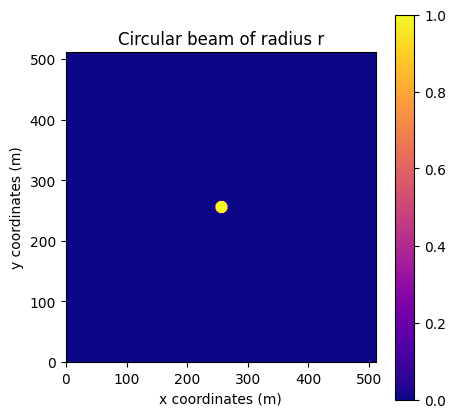

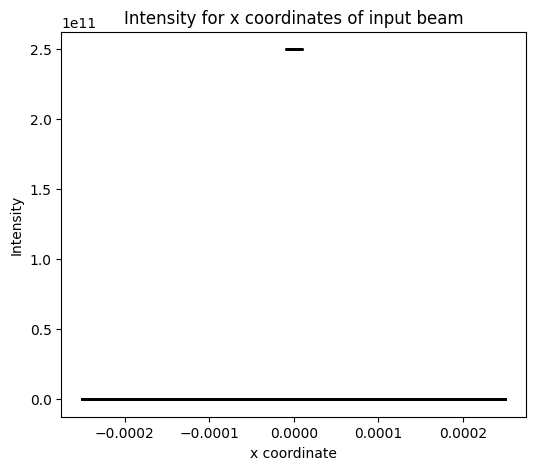

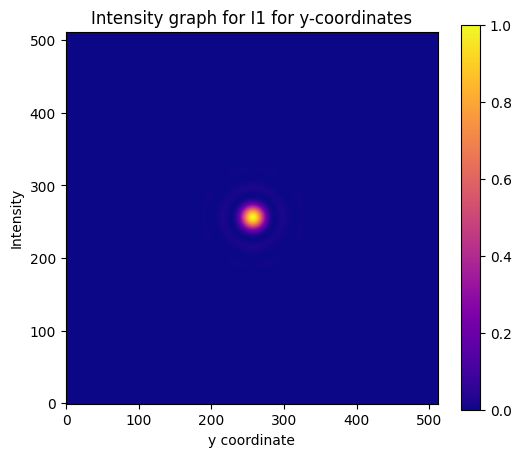

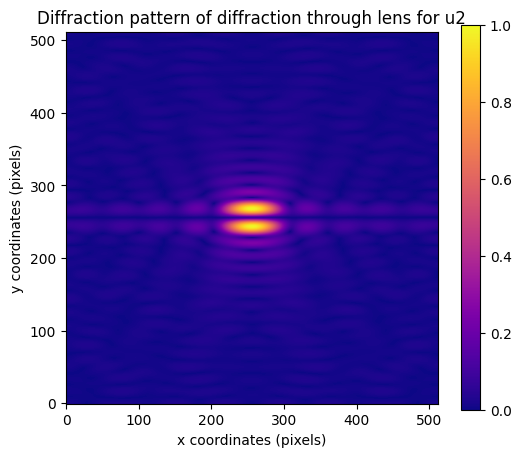

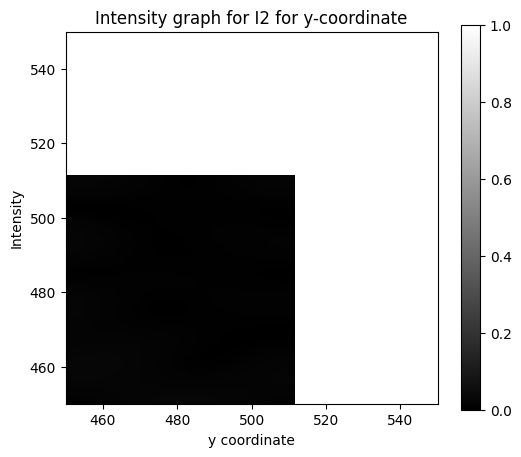

In [8]:
#initial_wf_file = fits.open("proc_val_2.fits")
#real_part = initial_wf_file['REAL'].data
#imag_part = initial_wf_file['IMAG'].data
#initial_wf = real_part + 1j * imag_part

from Fourf_optical_system_simulation_v1 import u2
print(u2)

Text(0, 0.5, 'y coordinates (pixels)')

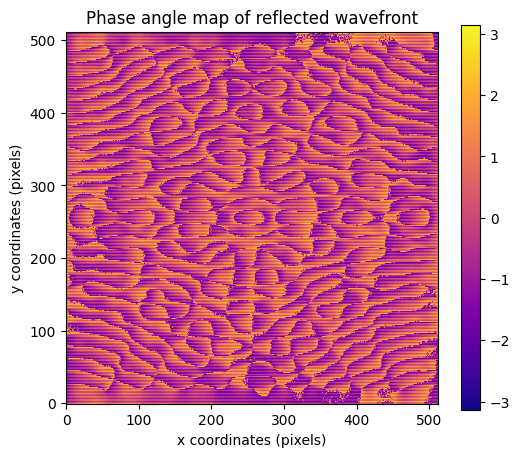

In [11]:
from numpy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift

#phase_scale = 20
u2 = fftshift(u2)
reflected_wf = u2*np.exp(1j*2*scaled_dm)

wvl = 200e-9 # wavelength
f = 10 # distance

reflected_wf = fftshift(reflected_wf)
#reflected_wf = fftshift(fft2(reflected_wf))

#I_reflected = (1/(wvl*f))**2*np.abs(reflected_wf)**2

#I_normalised = I_reflected
#I_normalised = (I_reflected - np.min(I_reflected))/(np.max(I_reflected) - np.min(I_reflected))

#plt.imshow(np.abs(reflected_wf), cmap='plasma', origin = 'lower')

plt.figure(figsize=(6,5))

plt.imshow(np.angle(reflected_wf), cmap='plasma', origin = 'lower')
#plt.imshow(I_normalised, cmap='plasma', origin='lower')
#plt.clim(0, 0.001)
plt.colorbar()
plt.title("Phase angle map of reflected wavefront")
plt.xlabel("x coordinates (pixels)")
plt.ylabel("y coordinates (pixels)")

Text(0, 0.5, 'y (pixels)')

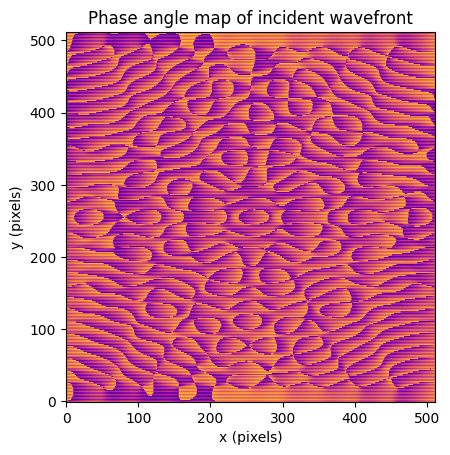

In [12]:
plt.imshow(np.angle(fftshift(u2)), origin = 'lower', cmap = 'plasma')
plt.title("Phase angle map of incident wavefront")
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")